# AAVE V3 Carry Trade Sustainability Analysis

## Strategy description
- **Deposit**: USDC (earn supply APR)
- **Borrow**: WETH (pay borrow APR)
- **LTV**: 50%
- **Goal**: Analyze profitability and liquidation risk 

## Modeling Approach
1. **CIR Model**: Cox-Ingersoll-Ross for interest rate dynamics
2. **CIR + Jumps**: CIR with Poisson-Exponential jumps for rate spikes
3. **Price Dynamics**: Historical WETH/USDC from provided data (not available in this repo)
4. **Monte Carlo**: 10,000 simulation paths for forward projections

---
## 1. Setup and Configuration

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize, differential_evolution
from scipy.special import iv  # Modified Bessel function for CIR MLE
from dataclasses import dataclass
from typing import Tuple, Optional, Dict, List
import warnings
warnings.filterwarnings('ignore')

# Plotting configuration - clean style with transparent background
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['axes.grid'] = False

# Random seed for reproducibility
np.random.seed(42)

In [81]:
@dataclass
class StrategyConfig:
    """Configuration for the AAVE V3 carry trade strategy."""
    initial_collateral_usdc: float = 100_000  # Initial USDC deposit
    ltv_ratio: float = 0.50  # Loan-to-value ratio (conservative)
    liquidation_threshold: float = 0.825  # AAVE V3 USDC liquidation threshold
    liquidation_penalty: float = 0.05  # 5% liquidation penalty
    n_simulations: int = 10_000  # Monte Carlo paths
    dt: float = 1/365  # Daily time steps (in years)
    
config = StrategyConfig()
print(f"Strategy Configuration:")
print(f"  Initial Collateral: ${config.initial_collateral_usdc:,.0f} USDC")
print(f"  LTV Ratio: {config.ltv_ratio:.0%}")
print(f"  Liquidation Threshold: {config.liquidation_threshold:.1%}")
print(f"  Simulations: {config.n_simulations:,}")

Strategy Configuration:
  Initial Collateral: $100,000 USDC
  LTV Ratio: 50%
  Liquidation Threshold: 82.5%
  Simulations: 10,000


---
## 2. Data Loading and Exploration

**Expected CSV format:**
- `timestamp`: Unix timestamp or datetime
- `usdc_supply_rate`: USDC supply APY (as decimal, e.g., 0.05 for 5%)
- `weth_borrow_rate`: WETH borrow APY (as decimal)
- `weth_price`: WETH/USDC price

In [82]:
# ===== LOAD AAVE V3 DATA =====
# Load USDC (supply) and WETH (borrow) data from AAVE V3

# Go up one level from src/ to reach data/AAVE/
DATA_DIR = "../data/AAVE/"
USDC_FILE = DATA_DIR + "aave_v3_usdc_eth.csv"
WETH_FILE = DATA_DIR + "aave_v3_weth_eth.csv"

# Load both datasets
try:
    df_usdc = pd.read_csv(USDC_FILE)
    df_weth = pd.read_csv(WETH_FILE)
    print(f"Loaded USDC data: {len(df_usdc):,} rows from {USDC_FILE}")
    print(f"Loaded WETH data: {len(df_weth):,} rows from {WETH_FILE}")
    print(f"\nUSdc columns: {list(df_usdc.columns)}")
    print(f"WETH columns: {list(df_weth.columns)}")
    
    # The first column 'timestamp' in the CSV is actually datetime string, 
    # and there's a separate numeric 'timestamp' column with unix timestamps
    # Use the index column which has the datetime string
    df_usdc['datetime'] = pd.to_datetime(df_usdc.iloc[:, 0])
    df_weth['datetime'] = pd.to_datetime(df_weth.iloc[:, 0])
    
    # Merge on datetime - keep USDC supply rate and WETH borrow rate
    df_raw = pd.merge(
        df_usdc[['datetime', 'lender_variable_apr', 'close']].rename(columns={
            'datetime': 'timestamp',
            'lender_variable_apr': 'usdc_supply_rate',
            'close': 'usdc_price'
        }),
        df_weth[['datetime', 'borrower_variable_apr', 'close']].rename(columns={
            'datetime': 'timestamp',
            'borrower_variable_apr': 'weth_borrow_rate',
            'close': 'weth_price'
        }),
        on='timestamp',
        how='inner'
    )
    
    # Column mapping for downstream processing
    COLUMN_MAP = {
        'timestamp': 'timestamp',
        'usdc_supply_rate': 'usdc_supply_rate',
        'weth_borrow_rate': 'weth_borrow_rate',
        'weth_price': 'weth_price'
    }
    
    print(f"\nMerged dataset: {len(df_raw):,} rows")
    print(f"Date range: {df_raw['timestamp'].min()} to {df_raw['timestamp'].max()}")
    print(f"\nSample data:")
    print(df_raw.head())
    
except FileNotFoundError as e:
    print(f"ERROR: File not found - {e}")
    print("Please ensure the data files exist in the data/AAVE/ directory.")
    df_raw = None

Loaded USDC data: 26,208 rows from ../data/AAVE/aave_v3_usdc_eth.csv
Loaded WETH data: 26,208 rows from ../data/AAVE/aave_v3_weth_eth.csv

USdc columns: ['Unnamed: 0', 'timestamp', 'block', 'TVL_USD', 'supplied_USD', 'borrowed_USD', 'liquidations', 'token_balance', 'close', 'lender_variable_apr', 'lender_stable_apr', 'borrower_variable_apr', 'borrower_stable_apr']
WETH columns: ['Unnamed: 0', 'timestamp', 'block', 'TVL_USD', 'supplied_USD', 'borrowed_USD', 'liquidations', 'token_balance', 'close', 'lender_variable_apr', 'lender_stable_apr', 'borrower_variable_apr', 'borrower_stable_apr']

Merged dataset: 26,208 rows
Date range: 2023-01-27 08:00:00 to 2026-01-23 07:00:00

Sample data:
            timestamp  usdc_supply_rate  usdc_price  weth_borrow_rate  \
0 2023-01-27 08:00:00               NaN    0.000000               NaN   
1 2023-01-27 09:00:00          0.000000    0.999954          1.064176   
2 2023-01-27 10:00:00          0.008496    0.999954          1.672405   
3 2023-01-27 11

In [83]:
def preprocess_data(df: pd.DataFrame, col_map: dict) -> pd.DataFrame:
    """Preprocess raw data into standardized format."""
    df = df.copy()
    
    # Rename columns to standard names
    rename_map = {v: k for k, v in col_map.items() if v in df.columns}
    df = df.rename(columns=rename_map)
    
    # Parse timestamp
    if 'timestamp' in df.columns:
        # Try multiple timestamp formats
        if df['timestamp'].dtype in ['int64', 'float64']:
            # Unix timestamp (seconds or milliseconds)
            if df['timestamp'].iloc[0] > 1e12:
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            else:
                df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        else:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    df = df.set_index('timestamp').sort_index()
    
    # Ensure rates are in decimal form (not percentage)
    for col in ['usdc_supply_rate', 'weth_borrow_rate']:
        if col in df.columns and df[col].mean() > 1:
            print(f"Converting {col} from percentage to decimal")
            df[col] = df[col] / 100
    
    # Calculate spread (what we earn - what we pay)
    df['rate_spread'] = df['usdc_supply_rate'] - df['weth_borrow_rate']
    
    # Calculate daily returns for WETH price
    df['weth_return'] = df['weth_price'].pct_change()
    
    return df.dropna()

# Process data if loaded
if df_raw is not None:
    df = preprocess_data(df_raw, COLUMN_MAP)
    print(f"\nProcessed data shape: {df.shape}")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    print(f"Duration: {(df.index.max() - df.index.min()).days} days")
else:
    df = None

Converting usdc_supply_rate from percentage to decimal
Converting weth_borrow_rate from percentage to decimal

Processed data shape: (26207, 6)
Date range: 2023-01-27 09:00:00 to 2026-01-23 07:00:00
Duration: 1091 days


In [84]:
# Data exploration and summary statistics
if df is not None:
    print("=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    
    stats_df = df[['usdc_supply_rate', 'weth_borrow_rate', 'rate_spread', 'weth_price']].describe()
    stats_df.loc['annualized_vol'] = df[['usdc_supply_rate', 'weth_borrow_rate', 'rate_spread']].std() * np.sqrt(365)
    
    print(stats_df.round(4))
    
    print(f"\n--- Key Insights ---")
    print(f"Average USDC Supply Rate: {df['usdc_supply_rate'].mean()*100:.2f}%")
    print(f"Average WETH Borrow Rate: {df['weth_borrow_rate'].mean()*100:.2f}%")
    print(f"Average Rate Spread: {df['rate_spread'].mean()*100:.2f}%")
    print(f"Spread > 0 (profitable): {(df['rate_spread'] > 0).mean()*100:.1f}% of time")
    print(f"WETH Price Range: ${df['weth_price'].min():,.0f} - ${df['weth_price'].max():,.0f}")

SUMMARY STATISTICS
                usdc_supply_rate  weth_borrow_rate  rate_spread  weth_price
count                 26207.0000        26207.0000   26207.0000  26207.0000
mean                      0.0498            0.0286       0.0212   2674.5083
std                       0.0333            0.0075       0.0357    824.2237
min                       0.0000            0.0106      -0.1757   1380.5211
25%                       0.0298            0.0250       0.0012   1877.5900
50%                       0.0407            0.0264       0.0152   2562.3197
75%                       0.0615            0.0319       0.0339   3312.9674
max                       0.5707            0.2264       0.5363   4925.5300
annualized_vol            0.6371            0.1426       0.6820         NaN

--- Key Insights ---
Average USDC Supply Rate: 4.98%
Average WETH Borrow Rate: 2.86%
Average Rate Spread: 2.12%
Spread > 0 (profitable): 76.1% of time
WETH Price Range: $1,381 - $4,926


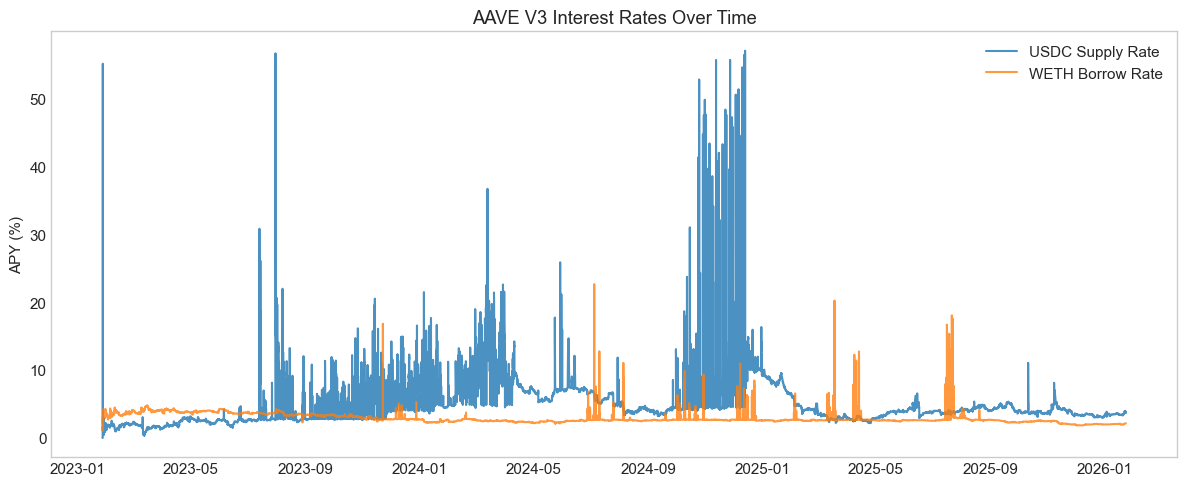

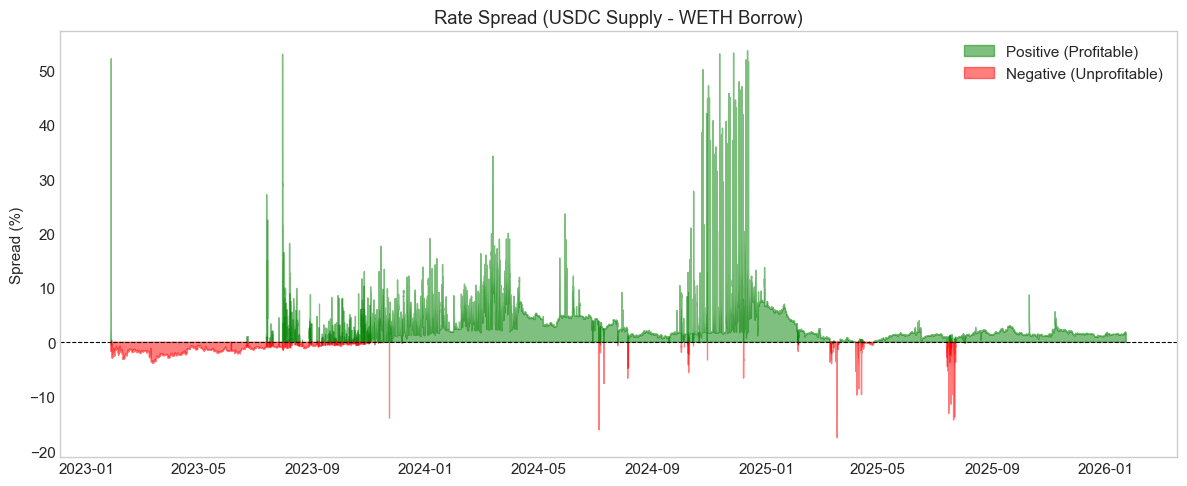

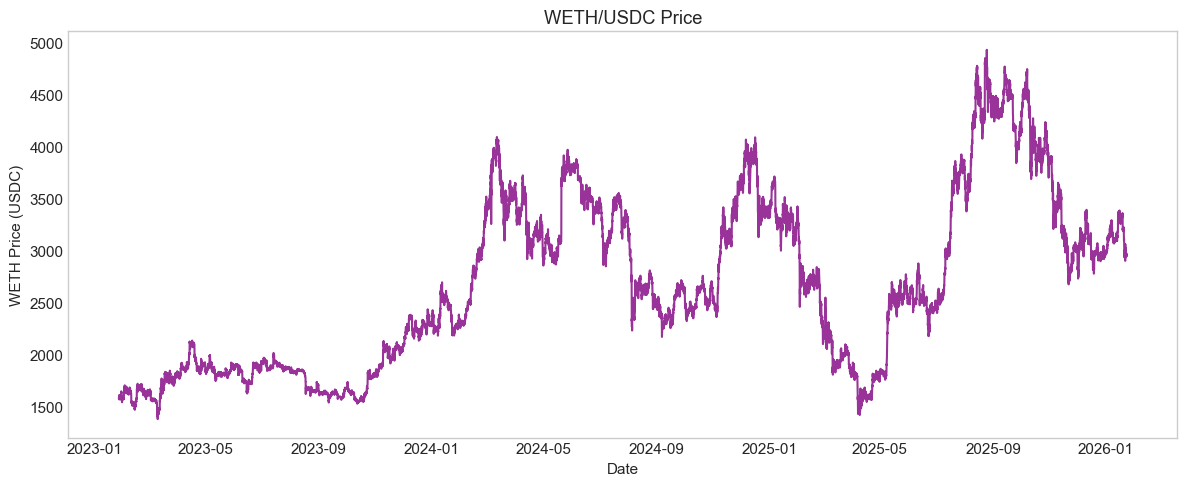

In [85]:
# Visualize historical data
if df is not None:
    # Plot 1: Interest Rates
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.patch.set_alpha(0)
    ax.plot(df.index, df['usdc_supply_rate']*100, label='USDC Supply Rate', alpha=0.8)
    ax.plot(df.index, df['weth_borrow_rate']*100, label='WETH Borrow Rate', alpha=0.8)
    ax.set_ylabel('APY (%)')
    ax.set_title('AAVE V3 Interest Rates Over Time')
    ax.legend()
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Rate Spread
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.patch.set_alpha(0)
    ax.fill_between(df.index, df['rate_spread']*100, 0, 
                     where=df['rate_spread'] >= 0, alpha=0.5, color='green', label='Positive (Profitable)')
    ax.fill_between(df.index, df['rate_spread']*100, 0,
                     where=df['rate_spread'] < 0, alpha=0.5, color='red', label='Negative (Unprofitable)')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_ylabel('Spread (%)')
    ax.set_title('Rate Spread (USDC Supply - WETH Borrow)')
    ax.legend()
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()
    
    # Plot 3: WETH Price
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.patch.set_alpha(0)
    ax.plot(df.index, df['weth_price'], color='purple', alpha=0.8)
    ax.set_ylabel('WETH Price (USDC)')
    ax.set_xlabel('Date')
    ax.set_title('WETH/USDC Price')
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()

---
## 3. CIR Model Implementation and Calibration

The Cox-Ingersoll-Ross (CIR) model describes interest rate dynamics as:

$$dr_t = \kappa(\theta - r_t)dt + \sigma\sqrt{r_t}dW_t$$

Where:
- $\kappa$: Speed of mean reversion
- $\theta$: Long-term mean rate
- $\sigma$: Volatility
- $W_t$: Wiener process

**Feller Condition**: $2\kappa\theta > \sigma^2$ ensures rates stay positive.

In [86]:
@dataclass
class CIRParams:
    """Parameters for the CIR model."""
    kappa: float  # Mean reversion speed
    theta: float  # Long-term mean
    sigma: float  # Volatility
    
    def __post_init__(self):
        self.feller_ratio = 2 * self.kappa * self.theta / (self.sigma ** 2)
        
    @property
    def feller_satisfied(self) -> bool:
        """Check if Feller condition is satisfied (rates stay positive)."""
        return self.feller_ratio > 1
    
    def __repr__(self):
        return (f"CIRParams(kappa={self.kappa:.4f}, theta={self.theta:.4f}, "
                f"sigma={self.sigma:.4f}, feller={self.feller_ratio:.2f})")

In [87]:
def cir_log_likelihood(params: Tuple[float, float, float], 
                       rates: np.ndarray, 
                       dt: float) -> float:
    """
    Compute negative log-likelihood for CIR model using exact transition density.
    
    The CIR transition density is a non-central chi-squared distribution.
    """
    kappa, theta, sigma = params
    
    # Parameter constraints
    if kappa <= 0 or theta <= 0 or sigma <= 0:
        return 1e10
    
    # Feller condition (soft constraint)
    if 2 * kappa * theta <= sigma ** 2:
        return 1e10
    
    n = len(rates)
    r_t = rates[:-1]
    r_t1 = rates[1:]
    
    # CIR transition density parameters
    c = 2 * kappa / (sigma**2 * (1 - np.exp(-kappa * dt)))
    q = 2 * kappa * theta / sigma**2 - 1
    u = c * r_t * np.exp(-kappa * dt)
    v = c * r_t1
    
    # Non-central chi-squared log density
    # Using the relationship with modified Bessel function
    try:
        # Log likelihood calculation
        log_lik = np.sum(
            np.log(c) + 
            (q/2) * np.log(v/u) - 
            u - v + 
            np.log(iv(q, 2 * np.sqrt(u * v)) + 1e-300)
        )
        
        if np.isnan(log_lik) or np.isinf(log_lik):
            return 1e10
            
        return -log_lik  # Return negative for minimization
        
    except (RuntimeWarning, FloatingPointError):
        return 1e10


def calibrate_cir_mle(rates: np.ndarray, dt: float = 1/365) -> CIRParams:
    """
    Calibrate CIR model using Maximum Likelihood Estimation.
    """
    # Initial guess using method of moments
    theta_init = np.mean(rates)
    sigma_init = np.std(np.diff(rates)) * np.sqrt(1/dt) / np.sqrt(theta_init)
    kappa_init = 1.0  # Starting guess for mean reversion
    
    # Ensure Feller condition in initial guess
    if 2 * kappa_init * theta_init <= sigma_init**2:
        sigma_init = np.sqrt(kappa_init * theta_init * 0.9)
    
    x0 = [kappa_init, theta_init, sigma_init]
    
    # Bounds
    bounds = [(0.01, 50), (1e-6, 1.0), (1e-6, 2.0)]
    
    # Optimize using differential evolution (more robust)
    result = differential_evolution(
        cir_log_likelihood,
        bounds=bounds,
        args=(rates, dt),
        seed=42,
        maxiter=1000,
        tol=1e-8,
        polish=True
    )
    
    return CIRParams(*result.x)

In [88]:
# Calibrate CIR models for both rates
if df is not None:
    # Resample to daily if needed (for consistent dt)
    df_daily = df.resample('D').mean().dropna()
    
    print("Calibrating CIR model for USDC Supply Rate...")
    usdc_rates = df_daily['usdc_supply_rate'].values
    usdc_rates = np.maximum(usdc_rates, 1e-6)  # Ensure positive
    cir_usdc = calibrate_cir_mle(usdc_rates)
    print(f"  {cir_usdc}")
    print(f"  Feller condition satisfied: {cir_usdc.feller_satisfied}")
    
    print("\nCalibrating CIR model for WETH Borrow Rate...")
    weth_rates = df_daily['weth_borrow_rate'].values
    weth_rates = np.maximum(weth_rates, 1e-6)  # Ensure positive
    cir_weth = calibrate_cir_mle(weth_rates)
    print(f"  {cir_weth}")
    print(f"  Feller condition satisfied: {cir_weth.feller_satisfied}")
else:
    cir_usdc, cir_weth = None, None

Calibrating CIR model for USDC Supply Rate...
  CIRParams(kappa=28.8251, theta=0.0495, sigma=0.8230, feller=4.22)
  Feller condition satisfied: True

Calibrating CIR model for WETH Borrow Rate...
  CIRParams(kappa=50.0000, theta=0.0289, sigma=0.3731, feller=20.75)
  Feller condition satisfied: True


In [89]:
def simulate_cir(params: CIRParams, 
                 r0: float, 
                 T: float, 
                 dt: float, 
                 n_paths: int) -> np.ndarray:
    """
    Simulate CIR paths using the Euler-Maruyama scheme with reflection.
    
    Args:
        params: CIR model parameters
        r0: Initial rate
        T: Time horizon (in years)
        dt: Time step (in years)
        n_paths: Number of simulation paths
    
    Returns:
        Array of shape (n_steps+1, n_paths) with simulated rates
    """
    n_steps = int(T / dt)
    rates = np.zeros((n_steps + 1, n_paths))
    rates[0] = r0
    
    sqrt_dt = np.sqrt(dt)
    
    for t in range(n_steps):
        r_t = rates[t]
        dW = np.random.randn(n_paths) * sqrt_dt
        
        # Euler-Maruyama step
        dr = params.kappa * (params.theta - r_t) * dt + params.sigma * np.sqrt(np.maximum(r_t, 0)) * dW
        rates[t + 1] = np.maximum(r_t + dr, 1e-8)  # Reflection at zero
    
    return rates


# Test CIR simulation
if cir_usdc is not None:
    print("Testing CIR simulation...")
    test_paths = simulate_cir(cir_usdc, usdc_rates[-1], T=1.0, dt=1/365, n_paths=100)
    print(f"Simulated {test_paths.shape[1]} paths over {test_paths.shape[0]-1} days")
    print(f"Final rate range: {test_paths[-1].min()*100:.2f}% - {test_paths[-1].max()*100:.2f}%")

Testing CIR simulation...
Simulated 100 paths over 365 days
Final rate range: 0.14% - 15.36%


---
## 4. CIR + Jumps Model (Poisson-Exponential), jump size capped at 30% APR 
We extend the CIR model with jumps:

$$dr_t = \kappa(\theta - r_t)dt + \sigma\sqrt{r_t}dW_t + J_t dN_t$$

Where:
- $N_t$: Poisson process with intensity $\lambda$ (jump frequency)
- $J_t$: Jump size drawn from Exponential($\mu$) distribution (asymmetric upward jumps)

This captures sudden rate spikes common in DeFi lending protocols.

In [90]:
@dataclass
class CIRJumpParams:
    """Parameters for CIR model with Poisson-Exponential jumps."""
    # CIR parameters
    kappa: float
    theta: float
    sigma: float
    # Jump parameters
    jump_intensity: float  # lambda: average jumps per year
    jump_mean: float  # mu: mean jump size (exponential distribution)
    
    @property
    def expected_jump_contribution(self) -> float:
        """Expected contribution from jumps per year."""
        return self.jump_intensity * self.jump_mean
    
    def __repr__(self):
        return (f"CIRJumpParams(kappa={self.kappa:.4f}, theta={self.theta:.4f}, "
                f"sigma={self.sigma:.4f}, lambda={self.jump_intensity:.2f}, "
                f"mu={self.jump_mean:.4f})")

In [91]:
def detect_jumps(rates: np.ndarray, threshold_std: float = 3.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Detect jumps in rate series using threshold method.
    
    Returns:
        jump_indices: Indices where jumps occurred
        jump_sizes: Size of each jump
    """
    rate_changes = np.diff(rates)
    
    # Use robust statistics (MAD) to identify outliers
    median = np.median(rate_changes)
    mad = np.median(np.abs(rate_changes - median))
    threshold = median + threshold_std * 1.4826 * mad  # 1.4826 scales MAD to std
    
    # Only count positive jumps (rate spikes)
    jump_mask = rate_changes > threshold
    jump_indices = np.where(jump_mask)[0]
    jump_sizes = rate_changes[jump_mask]
    
    return jump_indices, jump_sizes


def calibrate_cir_jump(rates: np.ndarray, dt: float = 1/365) -> CIRJumpParams:
    """
    Calibrate CIR + Jump model using a two-step approach:
    1. Detect and remove jumps
    2. Calibrate CIR on filtered series
    3. Calibrate jump parameters from detected jumps
    """
    # Step 1: Detect jumps
    jump_indices, jump_sizes = detect_jumps(rates)
    
    # Step 2: Remove jumps and calibrate CIR
    rates_filtered = rates.copy()
    for idx, size in zip(jump_indices, jump_sizes):
        # Remove jump effect from subsequent rates
        rates_filtered[idx+1:] -= size
    rates_filtered = np.maximum(rates_filtered, 1e-6)
    
    cir_params = calibrate_cir_mle(rates_filtered, dt)
    
    # Step 3: Calibrate jump parameters
    n_days = len(rates) - 1
    n_years = n_days * dt
    
    if len(jump_sizes) > 0:
        jump_intensity = len(jump_sizes) / n_years  # Jumps per year
        jump_mean = np.mean(jump_sizes)  # MLE for exponential
    else:
        # No jumps detected - use small default values
        jump_intensity = 1.0  # 1 jump per year
        jump_mean = 0.01  # 1% jump size
    
    return CIRJumpParams(
        kappa=cir_params.kappa,
        theta=cir_params.theta,
        sigma=cir_params.sigma,
        jump_intensity=jump_intensity,
        jump_mean=jump_mean
    )

In [92]:
# Calibrate CIR + Jump models
if df is not None:
    print("Calibrating CIR + Jump model for USDC Supply Rate...")
    jump_idx_usdc, jump_sizes_usdc = detect_jumps(usdc_rates)
    print(f"  Detected {len(jump_idx_usdc)} jumps in USDC rate")
    cir_jump_usdc = calibrate_cir_jump(usdc_rates)
    print(f"  {cir_jump_usdc}")
    
    print("\nCalibrating CIR + Jump model for WETH Borrow Rate...")
    jump_idx_weth, jump_sizes_weth = detect_jumps(weth_rates)
    print(f"  Detected {len(jump_idx_weth)} jumps in WETH rate")
    cir_jump_weth = calibrate_cir_jump(weth_rates)
    print(f"  {cir_jump_weth}")
else:
    cir_jump_usdc, cir_jump_weth = None, None

Calibrating CIR + Jump model for USDC Supply Rate...
  Detected 108 jumps in USDC rate
  CIRJumpParams(kappa=25.3904, theta=0.0013, sigma=0.2523, lambda=36.10, mu=0.0222)

Calibrating CIR + Jump model for WETH Borrow Rate...
  Detected 87 jumps in WETH rate
  CIRJumpParams(kappa=50.0000, theta=1.0000, sigma=0.0000, lambda=29.08, mu=0.0048)


In [93]:
def simulate_cir_jump(params: CIRJumpParams,
                      r0: float,
                      T: float,
                      dt: float,
                      n_paths: int,
                      max_rate: float = 0.30) -> np.ndarray:
    """
    Simulate CIR + Jump paths.
    
    Jumps follow Poisson process with Exponential jump sizes (always positive).
    Rates are capped at max_rate (default 30% APR) to reflect realistic AAVE behavior.
    """
    n_steps = int(T / dt)
    rates = np.zeros((n_steps + 1, n_paths))
    rates[0] = min(r0, max_rate)
    
    sqrt_dt = np.sqrt(dt)
    jump_prob = params.jump_intensity * dt  # Probability of jump in each period
    
    # Cap jump sizes to ensure rates stay reasonable
    max_jump_size = max_rate - params.theta  # Max jump that keeps rate near ceiling
    
    for t in range(n_steps):
        r_t = rates[t]
        
        # Diffusion component (CIR)
        dW = np.random.randn(n_paths) * sqrt_dt
        dr_diffusion = (params.kappa * (params.theta - r_t) * dt + 
                       params.sigma * np.sqrt(np.maximum(r_t, 0)) * dW)
        
        # Jump component (Poisson-Exponential) with capped jump sizes
        jump_occurs = np.random.random(n_paths) < jump_prob
        jump_sizes = np.minimum(
            np.random.exponential(params.jump_mean, n_paths),
            max_jump_size  # Cap individual jump sizes
        )
        dr_jump = jump_occurs * jump_sizes
        
        # Apply changes and cap at max_rate
        rates[t + 1] = np.clip(r_t + dr_diffusion + dr_jump, 1e-8, max_rate)
    
    return rates


# Test CIR + Jump simulation
if cir_jump_weth is not None:
    print("Testing CIR + Jump simulation (with 30% APR cap)...")
    test_jump_paths = simulate_cir_jump(cir_jump_weth, weth_rates[-1], T=1.0, dt=1/365, n_paths=100)
    print(f"Final rate range: {test_jump_paths[-1].min()*100:.2f}% - {test_jump_paths[-1].max()*100:.2f}%")
    print(f"Max rate across all paths: {test_jump_paths.max()*100:.2f}%")

Testing CIR + Jump simulation (with 30% APR cap)...
Final rate range: 0.00% - 30.00%
Max rate across all paths: 30.00%


---
## 5. Monte Carlo Simulation Engine

Now we simulate the full carry trade strategy, including:
- Interest rate dynamics (CIR or CIR+Jump)
- WETH price dynamics (from historical data or bootstrap)
- Portfolio P&L calculation
- Liquidation event tracking

In [94]:
@dataclass
class SimulationResult:
    """Container for Monte Carlo simulation results."""
    # Time series (n_steps+1, n_paths)
    usdc_rates: np.ndarray
    weth_rates: np.ndarray
    weth_prices: np.ndarray
    collateral_values: np.ndarray  # USDC collateral value over time
    debt_values: np.ndarray  # WETH debt value in USDC over time
    ltv_ratios: np.ndarray  # Current LTV over time
    pnl: np.ndarray  # Cumulative P&L over time
    
    # Terminal values (n_paths,)
    final_pnl: np.ndarray
    liquidated: np.ndarray  # Boolean mask of liquidated paths
    liquidation_times: np.ndarray  # Time of liquidation (NaN if not liquidated)
    
    # Config
    dt: float
    T: float
    model_type: str  # 'CIR' or 'CIR_Jump'

In [95]:
def bootstrap_price_returns(historical_returns: np.ndarray, 
                            n_steps: int, 
                            n_paths: int) -> np.ndarray:
    """
    Bootstrap future price returns from historical data.
    Uses block bootstrap to preserve autocorrelation.
    """
    block_size = 5  # 5-day blocks to preserve short-term momentum
    n_blocks = int(np.ceil(n_steps / block_size))
    
    # Sample blocks with replacement
    n_available = len(historical_returns) - block_size
    block_starts = np.random.randint(0, n_available, size=(n_blocks, n_paths))
    
    # Build return paths
    returns = np.zeros((n_steps, n_paths))
    for i in range(n_blocks):
        for j in range(n_paths):
            start_idx = block_starts[i, j]
            end_idx = min(i * block_size + block_size, n_steps)
            start_pos = i * block_size
            length = min(block_size, n_steps - start_pos)
            returns[start_pos:start_pos + length, j] = historical_returns[start_idx:start_idx + length]
    
    return returns

In [96]:
def run_carry_trade_simulation(
    config: StrategyConfig,
    usdc_cir_params,  # CIRParams or CIRJumpParams
    weth_cir_params,  # CIRParams or CIRJumpParams
    initial_usdc_rate: float,
    initial_weth_rate: float,
    initial_weth_price: float,
    historical_returns: np.ndarray,
    T: float,  # Simulation horizon in years
    use_jumps: bool = False
) -> SimulationResult:
    """
    Run full Monte Carlo simulation of the carry trade strategy.
    """
    n_steps = int(T / config.dt)
    n_paths = config.n_simulations
    
    # Select simulation function based on model type
    sim_func = simulate_cir_jump if use_jumps else simulate_cir
    model_type = 'CIR_Jump' if use_jumps else 'CIR'
    
    # Simulate interest rates
    usdc_rates = sim_func(usdc_cir_params, initial_usdc_rate, T, config.dt, n_paths)
    weth_rates = sim_func(weth_cir_params, initial_weth_rate, T, config.dt, n_paths)
    
    # Simulate WETH prices using bootstrap
    price_returns = bootstrap_price_returns(historical_returns, n_steps, n_paths)
    weth_prices = np.zeros((n_steps + 1, n_paths))
    weth_prices[0] = initial_weth_price
    for t in range(n_steps):
        weth_prices[t + 1] = weth_prices[t] * (1 + price_returns[t])
    
    # Initialize position tracking
    # Collateral: USDC deposited (earns supply rate)
    # Debt: WETH borrowed (pays borrow rate, valued in USDC)
    
    collateral = np.zeros((n_steps + 1, n_paths))
    debt_weth = np.zeros((n_steps + 1, n_paths))  # Debt in WETH units
    debt_usdc = np.zeros((n_steps + 1, n_paths))  # Debt value in USDC
    ltv_ratios = np.zeros((n_steps + 1, n_paths))
    pnl = np.zeros((n_steps + 1, n_paths))
    
    # Initial position
    collateral[0] = config.initial_collateral_usdc
    initial_borrow_usdc = config.initial_collateral_usdc * config.ltv_ratio
    debt_weth[0] = initial_borrow_usdc / initial_weth_price
    debt_usdc[0] = initial_borrow_usdc
    ltv_ratios[0] = config.ltv_ratio
    
    # Track liquidations
    liquidated = np.zeros(n_paths, dtype=bool)
    liquidation_times = np.full(n_paths, np.nan)
    
    # Simulate forward
    for t in range(n_steps):
        # Active paths (not yet liquidated)
        active = ~liquidated
        
        # Accrue interest on collateral (daily compounding)
        daily_supply_rate = usdc_rates[t] * config.dt
        collateral[t + 1, active] = collateral[t, active] * (1 + daily_supply_rate[active])
        
        # Accrue interest on debt (daily compounding)
        daily_borrow_rate = weth_rates[t] * config.dt
        debt_weth[t + 1, active] = debt_weth[t, active] * (1 + daily_borrow_rate[active])
        
        # Update debt value in USDC
        debt_usdc[t + 1, active] = debt_weth[t + 1, active] * weth_prices[t + 1, active]
        
        # Calculate current LTV
        ltv_ratios[t + 1, active] = debt_usdc[t + 1, active] / collateral[t + 1, active]
        
        # Check for liquidations
        newly_liquidated = active & (ltv_ratios[t + 1] >= config.liquidation_threshold)
        liquidated |= newly_liquidated
        liquidation_times[newly_liquidated] = (t + 1) * config.dt
        
        # For liquidated positions, apply penalty and close
        liquidation_value = (collateral[t + 1, newly_liquidated] * 
                            (1 - config.liquidation_penalty) - 
                            debt_usdc[t + 1, newly_liquidated])
        
        # Carry forward liquidation state
        collateral[t + 1, liquidated] = 0
        debt_weth[t + 1, liquidated] = 0
        debt_usdc[t + 1, liquidated] = 0
        ltv_ratios[t + 1, liquidated] = 0
        
        # Calculate P&L: equity value = collateral - debt
        pnl[t + 1] = collateral[t + 1] - debt_usdc[t + 1] - config.initial_collateral_usdc * (1 - config.ltv_ratio)
    
    # Adjust P&L for liquidated paths
    for i in np.where(liquidated)[0]:
        liq_step = int(liquidation_times[i] / config.dt)
        liq_value = (collateral[liq_step, i] * (1 - config.liquidation_penalty) - 
                    debt_usdc[liq_step, i] - config.initial_collateral_usdc * (1 - config.ltv_ratio))
        pnl[liq_step:, i] = liq_value
    
    return SimulationResult(
        usdc_rates=usdc_rates,
        weth_rates=weth_rates,
        weth_prices=weth_prices,
        collateral_values=collateral,
        debt_values=debt_usdc,
        ltv_ratios=ltv_ratios,
        pnl=pnl,
        final_pnl=pnl[-1],
        liquidated=liquidated,
        liquidation_times=liquidation_times,
        dt=config.dt,
        T=T,
        model_type=model_type
    )

In [97]:
# Run simulations for both models
if df is not None and cir_usdc is not None:
    T_horizon = 1.0  # 1 year forward simulation
    
    # Get initial values from latest data
    initial_usdc_rate = usdc_rates[-1]
    initial_weth_rate = weth_rates[-1]
    initial_weth_price = df_daily['weth_price'].iloc[-1]
    historical_returns = df_daily['weth_return'].dropna().values
    
    print(f"Initial Conditions:")
    print(f"  USDC Supply Rate: {initial_usdc_rate*100:.2f}%")
    print(f"  WETH Borrow Rate: {initial_weth_rate*100:.2f}%")
    print(f"  WETH Price: ${initial_weth_price:,.2f}")
    print(f"  Historical return volatility: {np.std(historical_returns)*np.sqrt(365)*100:.1f}% annualized")
    
    print(f"\nRunning CIR model simulation ({config.n_simulations:,} paths)...")
    results_cir = run_carry_trade_simulation(
        config, cir_usdc, cir_weth,
        initial_usdc_rate, initial_weth_rate, initial_weth_price,
        historical_returns, T_horizon, use_jumps=False
    )
    print(f"  Completed. Liquidation rate: {results_cir.liquidated.mean()*100:.2f}%")
    
    print(f"\nRunning CIR + Jump model simulation ({config.n_simulations:,} paths)...")
    results_jump = run_carry_trade_simulation(
        config, cir_jump_usdc, cir_jump_weth,
        initial_usdc_rate, initial_weth_rate, initial_weth_price,
        historical_returns, T_horizon, use_jumps=True
    )
    print(f"  Completed. Liquidation rate: {results_jump.liquidated.mean()*100:.2f}%")
else:
    results_cir, results_jump = None, None

Initial Conditions:
  USDC Supply Rate: 3.71%
  WETH Borrow Rate: 2.13%
  WETH Price: $2,956.76
  Historical return volatility: nan% annualized

Running CIR model simulation (10,000 paths)...
  Completed. Liquidation rate: 6.93%

Running CIR + Jump model simulation (10,000 paths)...
  Completed. Liquidation rate: 6.65%


---
## 6. Liquidation Probability Analysis

The key risk metric: what's the probability of getting liquidated?

In [98]:
def analyze_liquidation_risk(result: SimulationResult, config: StrategyConfig) -> Dict:
    """Compute detailed liquidation risk metrics."""
    n_paths = len(result.liquidated)
    n_liquidated = result.liquidated.sum()
    
    metrics = {
        'model': result.model_type,
        'n_simulations': n_paths,
        'liquidation_probability': n_liquidated / n_paths,
        'liquidation_count': n_liquidated,
        'survival_probability': 1 - n_liquidated / n_paths,
    }
    
    if n_liquidated > 0:
        liq_times = result.liquidation_times[result.liquidated]
        metrics['mean_time_to_liquidation'] = np.mean(liq_times)
        metrics['median_time_to_liquidation'] = np.median(liq_times)
        metrics['min_time_to_liquidation'] = np.min(liq_times)
        metrics['max_time_to_liquidation'] = np.max(liq_times)
        
        # Time-based liquidation probabilities
        metrics['prob_liq_30d'] = (liq_times <= 30/365).mean() * metrics['liquidation_probability']
        metrics['prob_liq_90d'] = (liq_times <= 90/365).mean() * metrics['liquidation_probability']
        metrics['prob_liq_180d'] = (liq_times <= 180/365).mean() * metrics['liquidation_probability']
    else:
        metrics['mean_time_to_liquidation'] = np.nan
        metrics['median_time_to_liquidation'] = np.nan
        metrics['prob_liq_30d'] = 0
        metrics['prob_liq_90d'] = 0
        metrics['prob_liq_180d'] = 0
    
    # LTV distribution at terminal time (non-liquidated paths)
    surviving_ltv = result.ltv_ratios[-1, ~result.liquidated]
    if len(surviving_ltv) > 0:
        metrics['surviving_ltv_mean'] = np.mean(surviving_ltv)
        metrics['surviving_ltv_std'] = np.std(surviving_ltv)
        metrics['surviving_ltv_95th'] = np.percentile(surviving_ltv, 95)
        metrics['prob_ltv_above_75'] = (surviving_ltv > 0.75).mean()
    
    return metrics

In [99]:
# Analyze liquidation risk for both models
if results_cir is not None:
    liq_metrics_cir = analyze_liquidation_risk(results_cir, config)
    liq_metrics_jump = analyze_liquidation_risk(results_jump, config)
    
    print("=" * 70)
    print("LIQUIDATION RISK ANALYSIS")
    print("=" * 70)
    
    print(f"\n{'Metric':<40} {'CIR':>12} {'CIR+Jump':>12}")
    print("-" * 70)
    
    for key in ['liquidation_probability', 'survival_probability', 
                'prob_liq_30d', 'prob_liq_90d', 'prob_liq_180d']:
        v1 = liq_metrics_cir.get(key, 0)
        v2 = liq_metrics_jump.get(key, 0)
        print(f"{key:<40} {v1*100:>11.2f}% {v2*100:>11.2f}%")
    
    for key in ['mean_time_to_liquidation', 'median_time_to_liquidation']:
        v1 = liq_metrics_cir.get(key, np.nan)
        v2 = liq_metrics_jump.get(key, np.nan)
        if not np.isnan(v1) or not np.isnan(v2):
            print(f"{key:<40} {v1*365:>10.0f}d {v2*365:>10.0f}d")
    
    print("-" * 70)
    
    for key in ['surviving_ltv_mean', 'surviving_ltv_95th', 'prob_ltv_above_75']:
        v1 = liq_metrics_cir.get(key, 0)
        v2 = liq_metrics_jump.get(key, 0)
        if 'prob' in key:
            print(f"{key:<40} {v1*100:>11.2f}% {v2*100:>11.2f}%")
        else:
            print(f"{key:<40} {v1*100:>11.2f}% {v2*100:>11.2f}%")

LIQUIDATION RISK ANALYSIS

Metric                                            CIR     CIR+Jump
----------------------------------------------------------------------
liquidation_probability                         6.93%        6.65%
survival_probability                           93.07%       93.35%
prob_liq_30d                                    0.53%        0.55%
prob_liq_90d                                    1.64%        1.65%
prob_liq_180d                                   3.52%        3.28%
mean_time_to_liquidation                        180d        179d
median_time_to_liquidation                      176d        181d
----------------------------------------------------------------------
surviving_ltv_mean                             49.90%       63.84%
surviving_ltv_95th                             52.08%       66.73%
prob_ltv_above_75                               0.00%        0.00%


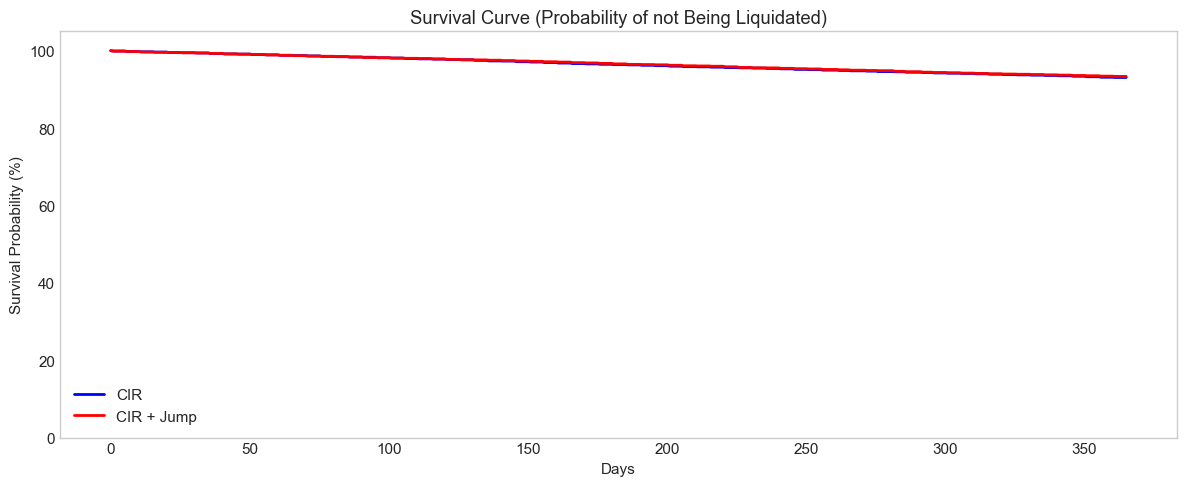

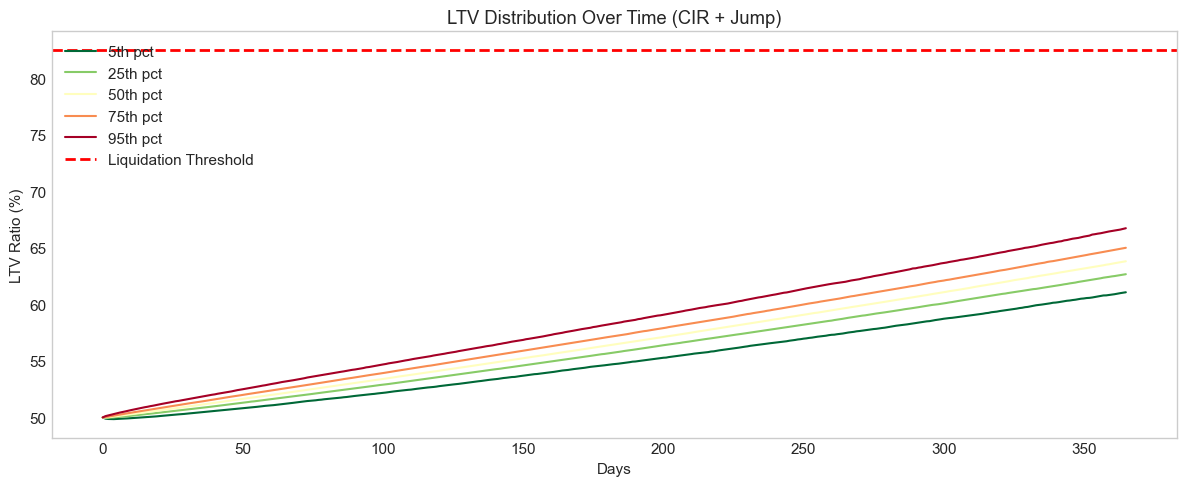

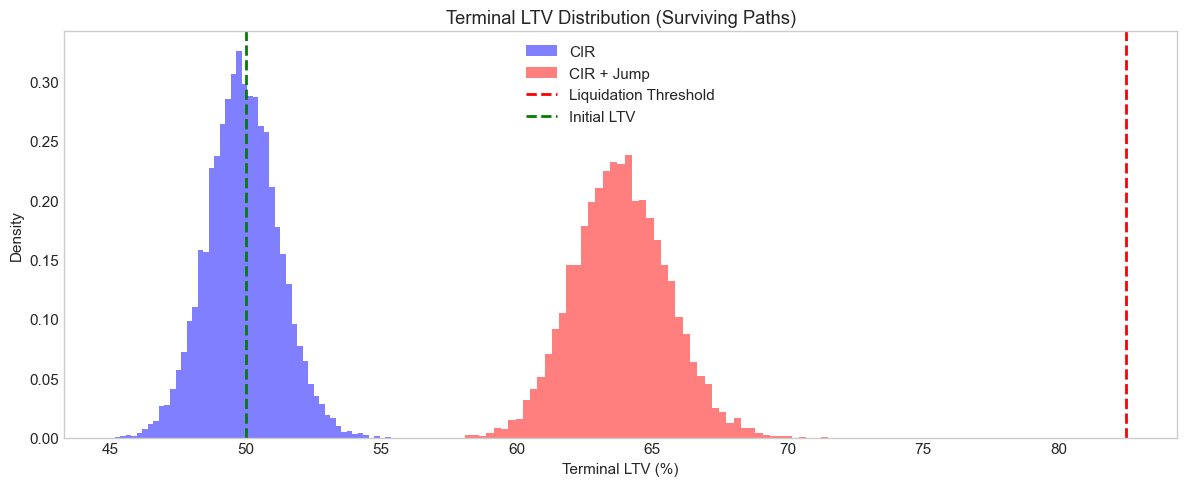

INTERPRETATION: Terminal LTV Distribution (Surviving Paths)

This histogram shows the LTV ratio at year-end for positions that avoided liquidation.

CIR Model (Blue):
  - Terminal LTV centers around 49.9% (started at 50%)
  - The tight distribution indicates stable debt-to-collateral dynamics
  - All surviving paths remain well below the 82.5% liquidation threshold

CIR + Jump Model (Red):
  - Terminal LTV shifts higher to ~63.8% on average
  - Wider spread reflects accumulated impact of rate spikes on debt growth
  - The rightward shift shows debt growing faster than collateral due to borrow rate jumps

Why LTV Increases Over Time:
  - WETH borrow rates (avg ~2.9%) often exceed USDC supply rates in jump scenarios
  - When borrow rate > supply rate, debt grows faster than collateral
  - WETH price appreciation can also increase debt value (denominated in USDC)

Risk Implication: Even surviving paths show LTV drift toward the liquidation threshold,
suggesting the position requires activ

In [107]:
# Visualize liquidation analysis
if results_cir is not None:
    time_points = np.arange(0, int(results_cir.T / results_cir.dt) + 1) * results_cir.dt * 365
    
    # Plot 1: Survival curves
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.patch.set_alpha(0)
    for result, label, color in [(results_cir, 'CIR', 'blue'), 
                                   (results_jump, 'CIR + Jump', 'red')]:
        survival = np.zeros(len(time_points))
        for i, t in enumerate(time_points / 365):
            survival[i] = (~result.liquidated | (result.liquidation_times > t)).mean()
        ax.plot(time_points, survival * 100, label=label, color=color, linewidth=2)
    ax.set_xlabel('Days')
    ax.set_ylabel('Survival Probability (%)')
    ax.set_title('Survival Curve (Probability of not Being Liquidated)')
    ax.legend()
    ax.set_ylim([0, 105])
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()
    
    # Plot 2: LTV distribution over time
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.patch.set_alpha(0)
    percentiles = [5, 25, 50, 75, 95]
    colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(percentiles)))
    ltv_over_time = results_jump.ltv_ratios.copy()
    ltv_over_time[ltv_over_time == 0] = np.nan
    for pct, color in zip(percentiles, colors):
        pct_values = np.nanpercentile(ltv_over_time, pct, axis=1) * 100
        ax.plot(time_points, pct_values, label=f'{pct}th pct', color=color, linewidth=1.5)
    ax.axhline(config.liquidation_threshold * 100, color='red', linestyle='--', 
                linewidth=2, label='Liquidation Threshold')
    ax.set_xlabel('Days')
    ax.set_ylabel('LTV Ratio (%)')
    ax.set_title('LTV Distribution Over Time (CIR + Jump)')
    ax.legend(loc='upper left')
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Terminal LTV distribution
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.patch.set_alpha(0)
    for result, label, color in [(results_cir, 'CIR', 'blue'), 
                                   (results_jump, 'CIR + Jump', 'red')]:
        terminal_ltv = result.ltv_ratios[-1, ~result.liquidated] * 100
        if len(terminal_ltv) > 0:
            ax.hist(terminal_ltv, bins=50, alpha=0.5, label=label, color=color, density=True)
    ax.axvline(config.liquidation_threshold * 100, color='red', linestyle='--', 
                linewidth=2, label='Liquidation Threshold')
    ax.axvline(config.ltv_ratio * 100, color='green', linestyle='--', 
                linewidth=2, label='Initial LTV')
    ax.set_xlabel('Terminal LTV (%)')
    ax.set_ylabel('Density')
    ax.set_title('Terminal LTV Distribution (Surviving Paths)')
    ax.legend()
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()
    
    # Interpretation for Terminal LTV Distribution
    cir_terminal_ltv = results_cir.ltv_ratios[-1, ~results_cir.liquidated] * 100
    jump_terminal_ltv = results_jump.ltv_ratios[-1, ~results_jump.liquidated] * 100
    
    print("=" * 70)
    print("INTERPRETATION: Terminal LTV Distribution (Surviving Paths)")
    print("=" * 70)
    print(f"""
This histogram shows the LTV ratio at year-end for positions that avoided liquidation.

CIR Model (Blue):
  - Terminal LTV centers around {np.mean(cir_terminal_ltv):.1f}% (started at {config.ltv_ratio*100:.0f}%)
  - The tight distribution indicates stable debt-to-collateral dynamics
  - All surviving paths remain well below the {config.liquidation_threshold*100:.1f}% liquidation threshold

CIR + Jump Model (Red):
  - Terminal LTV shifts higher to ~{np.mean(jump_terminal_ltv):.1f}% on average
  - Wider spread reflects accumulated impact of rate spikes on debt growth
  - The rightward shift shows debt growing faster than collateral due to borrow rate jumps

Why LTV Increases Over Time:
  - WETH borrow rates (avg ~2.9%) often exceed USDC supply rates in jump scenarios
  - When borrow rate > supply rate, debt grows faster than collateral
  - WETH price appreciation can also increase debt value (denominated in USDC)

Risk Implication: Even surviving paths show LTV drift toward the liquidation threshold,
suggesting the position requires active monitoring and potential deleveraging over time.
""")

---
## 7. P&L Analysis and Strategy Sustainability

In [101]:
def analyze_pnl(result: SimulationResult, config: StrategyConfig) -> Dict:
    """Compute P&L and risk metrics."""
    initial_equity = config.initial_collateral_usdc * (1 - config.ltv_ratio)
    final_pnl = result.final_pnl
    returns = final_pnl / initial_equity
    
    metrics = {
        'model': result.model_type,
        'initial_equity': initial_equity,
        'mean_pnl': np.mean(final_pnl),
        'median_pnl': np.median(final_pnl),
        'std_pnl': np.std(final_pnl),
        'mean_return': np.mean(returns),
        'std_return': np.std(returns),
        'sharpe_ratio': np.mean(returns) / np.std(returns) if np.std(returns) > 0 else 0,
        'min_pnl': np.min(final_pnl),
        'max_pnl': np.max(final_pnl),
        'pct_profitable': (final_pnl > 0).mean(),
        'var_95': np.percentile(final_pnl, 5),
        'cvar_95': np.mean(final_pnl[final_pnl <= np.percentile(final_pnl, 5)]),
        'var_99': np.percentile(final_pnl, 1),
        'cvar_99': np.mean(final_pnl[final_pnl <= np.percentile(final_pnl, 1)]),
    }
    
    # Conditional metrics (excluding liquidated paths)
    surviving = ~result.liquidated
    if surviving.sum() > 0:
        surviving_pnl = final_pnl[surviving]
        metrics['mean_pnl_if_survive'] = np.mean(surviving_pnl)
        metrics['pct_profitable_if_survive'] = (surviving_pnl > 0).mean()
    
    return metrics

In [102]:
# Analyze P&L for both models
if results_cir is not None:
    pnl_metrics_cir = analyze_pnl(results_cir, config)
    pnl_metrics_jump = analyze_pnl(results_jump, config)
    
    print("=" * 70)
    print("P&L AND PERFORMANCE ANALYSIS")
    print("=" * 70)
    print(f"Initial Equity (50% of collateral): ${pnl_metrics_cir['initial_equity']:,.0f}")
    print(f"Simulation Horizon: {results_cir.T:.1f} years")
    
    print(f"\n{'Metric':<40} {'CIR':>15} {'CIR+Jump':>15}")
    print("-" * 70)
    
    for key in ['mean_pnl', 'median_pnl', 'std_pnl', 'min_pnl', 'max_pnl']:
        v1 = pnl_metrics_cir.get(key, 0)
        v2 = pnl_metrics_jump.get(key, 0)
        print(f"{key:<40} ${v1:>13,.0f} ${v2:>13,.0f}")
    
    print("-" * 70)
    

    # Sharpe Ratio of 0
    for key in ['mean_return', 'std_return']:
        v1 = pnl_metrics_cir.get(key, 0)
        v2 = pnl_metrics_jump.get(key, 0)

    print("-" * 70)
    
    for key in ['pct_profitable', 'pct_profitable_if_survive']:
        v1 = pnl_metrics_cir.get(key, 0)
        v2 = pnl_metrics_jump.get(key, 0)
        print(f"{key:<40} {v1*100:>14.1f}% {v2*100:>14.1f}%")

P&L AND PERFORMANCE ANALYSIS
Initial Equity (50% of collateral): $50,000
Simulation Horizon: 1.0 years

Metric                                               CIR        CIR+Jump
----------------------------------------------------------------------
mean_pnl                                 $         -733 $      -14,873
median_pnl                               $        2,503 $      -12,755
std_pnl                                  $       12,864 $        9,075
min_pnl                                  $      -50,000 $      -50,000
max_pnl                                  $        8,056 $       -6,322
----------------------------------------------------------------------
----------------------------------------------------------------------
pct_profitable                                     89.4%            0.0%
pct_profitable_if_survive                          96.0%            0.0%


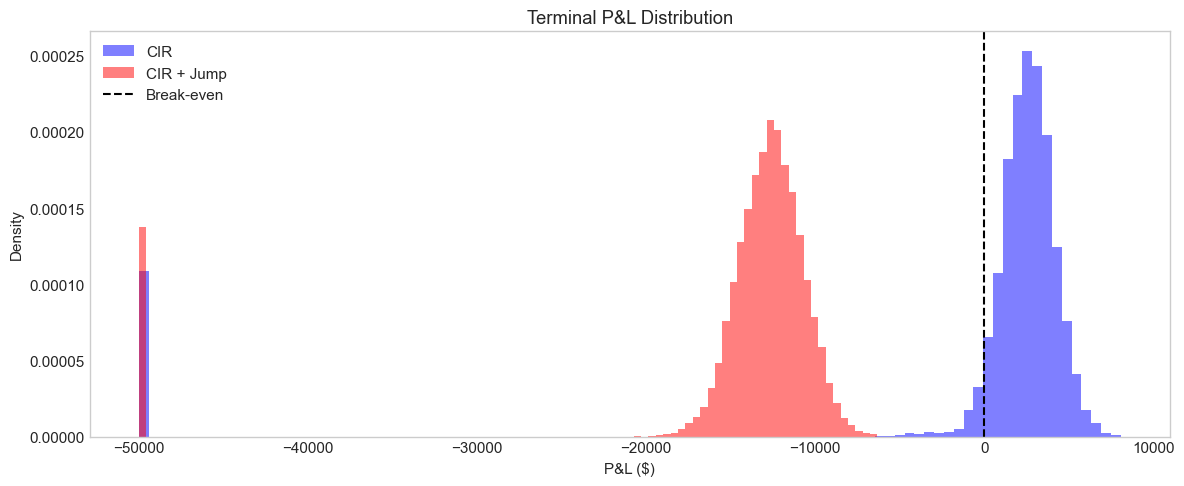

INTERPRETATION: Terminal P&L Distribution

The histogram shows the distribution of final P&L across 10,000 simulated paths.

CIR Model (Blue):
  - The distribution is centered around $-733 with 89.4% of paths profitable.
  - The tight clustering indicates relatively stable outcomes when rate dynamics 
    follow the mean-reverting CIR process without sudden spikes.

CIR + Jump Model (Red):
  - The distribution shifts left with mean P&L of $-14,873 and only 0.0% profitable.
  - The spike at -$50,000 represents liquidated positions (total equity loss).
  - Jump dynamics cause higher borrowing costs during rate spikes, eroding profits.

Key Insight: The CIR+Jump model better captures real DeFi rate behavior where sudden 
utilization spikes can dramatically increase borrow rates, making the carry trade 
less profitable than the smooth CIR model suggests.



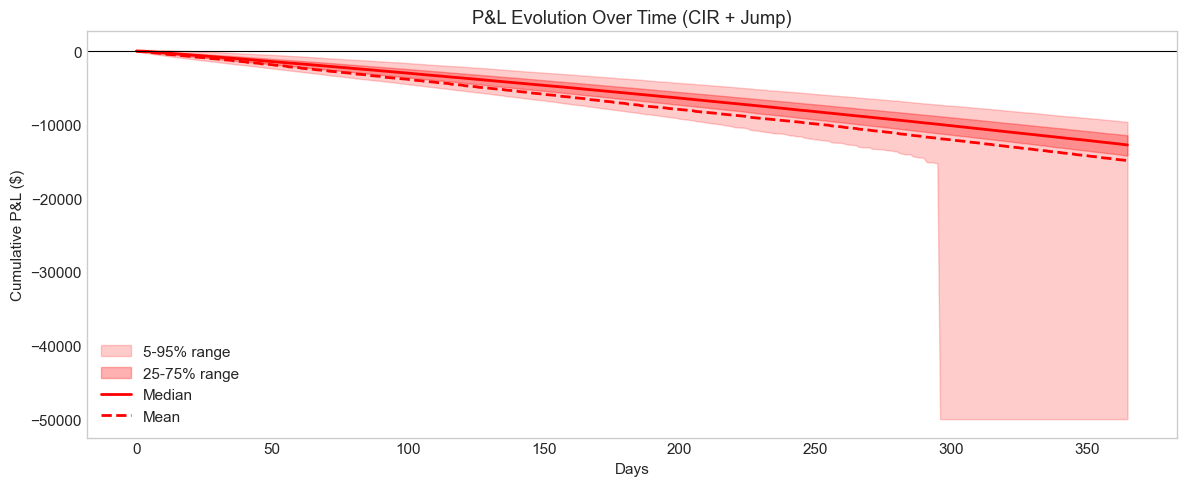

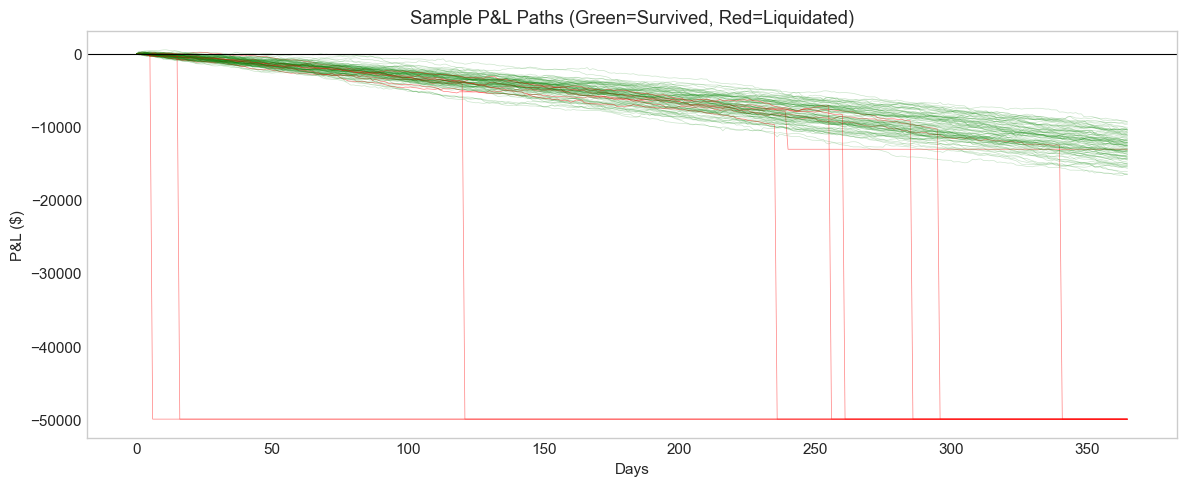

INTERPRETATION: Sample P&L Paths

This plot shows 100 randomly sampled simulation paths from the CIR+Jump model.

Green Paths (Survived):
  - These positions avoided liquidation throughout the 1-year horizon
  - Notice the steady downward drift as cumulative borrow costs exceed supply income
  - The fan-shaped spread reflects path-dependent outcomes from random rate/price shocks
  - Even survivors end with negative P&L due to unfavorable rate spreads

Red Paths (Liquidated):
  - Sharp vertical drops to -$50,000 mark liquidation events (total equity wipeout)
  - Liquidations occur when WETH price rises sharply OR accumulated rate costs push LTV 
    above the 82.5% threshold
  - ~6.7% of all paths experience liquidation, with average time-to-liquidation 
    of 179 days

Key Observations:
  1. P&L trajectories are predominantly negative - this carry trade loses money on average
  2. Liquidation risk concentrates in the second half of the year as LTV drifts higher
  3. The strategy exhib

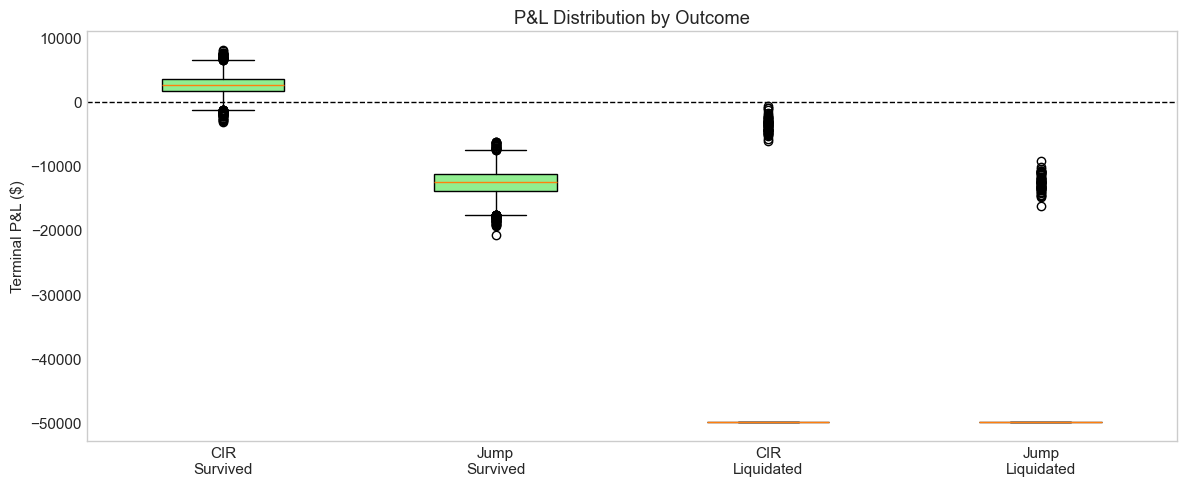

In [108]:
# Visualize P&L analysis
if results_cir is not None:
    time_days = np.arange(results_jump.pnl.shape[0]) * results_jump.dt * 365
    
    # Plot 1: P&L distribution
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.patch.set_alpha(0)
    for result, label, color in [(results_cir, 'CIR', 'blue'), 
                                   (results_jump, 'CIR + Jump', 'red')]:
        ax.hist(result.final_pnl, bins=100, alpha=0.5, label=label, color=color, density=True)
    ax.axvline(0, color='black', linestyle='--', linewidth=1.5, label='Break-even')
    ax.set_xlabel('P&L ($)')
    ax.set_ylabel('Density')
    ax.set_title('Terminal P&L Distribution')
    ax.legend()
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()
    
    # Print interpretation
    cir_mean = pnl_metrics_cir['mean_pnl']
    jump_mean = pnl_metrics_jump['mean_pnl']
    cir_pct_profit = pnl_metrics_cir['pct_profitable'] * 100
    jump_pct_profit = pnl_metrics_jump['pct_profitable'] * 100
    
    print("=" * 70)
    print("INTERPRETATION: Terminal P&L Distribution")
    print("=" * 70)
    print(f"""
The histogram shows the distribution of final P&L across {config.n_simulations:,} simulated paths.

CIR Model (Blue):
  - The distribution is centered around ${cir_mean:,.0f} with {cir_pct_profit:.1f}% of paths profitable.
  - The tight clustering indicates relatively stable outcomes when rate dynamics 
    follow the mean-reverting CIR process without sudden spikes.

CIR + Jump Model (Red):
  - The distribution shifts left with mean P&L of ${jump_mean:,.0f} and only {jump_pct_profit:.1f}% profitable.
  - The spike at -$50,000 represents liquidated positions (total equity loss).
  - Jump dynamics cause higher borrowing costs during rate spikes, eroding profits.

Key Insight: The CIR+Jump model better captures real DeFi rate behavior where sudden 
utilization spikes can dramatically increase borrow rates, making the carry trade 
less profitable than the smooth CIR model suggests.
""")
    
    # Plot 2: Cumulative P&L paths
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.patch.set_alpha(0)
    pnl = results_jump.pnl
    ax.fill_between(time_days, np.percentile(pnl, 5, axis=1), np.percentile(pnl, 95, axis=1),
                     alpha=0.2, color='red', label='5-95% range')
    ax.fill_between(time_days, np.percentile(pnl, 25, axis=1), np.percentile(pnl, 75, axis=1),
                     alpha=0.3, color='red', label='25-75% range')
    ax.plot(time_days, np.median(pnl, axis=1), 'r-', linewidth=2, label='Median')
    ax.plot(time_days, np.mean(pnl, axis=1), 'r--', linewidth=2, label='Mean')
    ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
    ax.set_xlabel('Days')
    ax.set_ylabel('Cumulative P&L ($)')
    ax.set_title('P&L Evolution Over Time (CIR + Jump)')
    ax.legend()
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Sample paths
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.patch.set_alpha(0)
    n_sample = 100
    sample_idx = np.random.choice(config.n_simulations, n_sample, replace=False)
    n_liq_sample = results_jump.liquidated[sample_idx].sum()
    for idx in sample_idx:
        color = 'red' if results_jump.liquidated[idx] else 'green'
        alpha = 0.5 if results_jump.liquidated[idx] else 0.2
        ax.plot(time_days, results_jump.pnl[:, idx], color=color, alpha=alpha, linewidth=0.5)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
    ax.set_xlabel('Days')
    ax.set_ylabel('P&L ($)')
    ax.set_title('Sample P&L Paths (Green=Survived, Red=Liquidated)')
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()
    
    # Interpretation for Sample P&L Paths
    liq_prob = results_jump.liquidated.mean() * 100
    liq_times = results_jump.liquidation_times[results_jump.liquidated]
    avg_liq_time = np.mean(liq_times) * 365 if len(liq_times) > 0 else 0
    
    print("=" * 70)
    print("INTERPRETATION: Sample P&L Paths")
    print("=" * 70)
    print(f"""
This plot shows {n_sample} randomly sampled simulation paths from the CIR+Jump model.

Green Paths (Survived):
  - These positions avoided liquidation throughout the 1-year horizon
  - Notice the steady downward drift as cumulative borrow costs exceed supply income
  - The fan-shaped spread reflects path-dependent outcomes from random rate/price shocks
  - Even survivors end with negative P&L due to unfavorable rate spreads

Red Paths (Liquidated):
  - Sharp vertical drops to -$50,000 mark liquidation events (total equity wipeout)
  - Liquidations occur when WETH price rises sharply OR accumulated rate costs push LTV 
    above the {config.liquidation_threshold*100:.1f}% threshold
  - ~{liq_prob:.1f}% of all paths experience liquidation, with average time-to-liquidation 
    of {avg_liq_time:.0f} days

Key Observations:
  1. P&L trajectories are predominantly negative - this carry trade loses money on average
  2. Liquidation risk concentrates in the second half of the year as LTV drifts higher
  3. The strategy exhibits "picking up pennies in front of a steamroller" characteristics:
     small ongoing losses with occasional catastrophic wipeouts
"""
    )
    
    # Plot 4: P&L by liquidation status
    fig, ax = plt.subplots(figsize=(12, 5))
    fig.patch.set_alpha(0)
    cir_survived_pnl = results_cir.final_pnl[~results_cir.liquidated]
    cir_liq_pnl = results_cir.final_pnl[results_cir.liquidated]
    jump_survived_pnl = results_jump.final_pnl[~results_jump.liquidated]
    jump_liq_pnl = results_jump.final_pnl[results_jump.liquidated]
    box_data = [
        cir_survived_pnl if len(cir_survived_pnl) > 0 else [0],
        jump_survived_pnl if len(jump_survived_pnl) > 0 else [0],
        cir_liq_pnl if len(cir_liq_pnl) > 0 else [0],
        jump_liq_pnl if len(jump_liq_pnl) > 0 else [0]
    ]
    bp = ax.boxplot(box_data, labels=['CIR\nSurvived', 'Jump\nSurvived', 'CIR\nLiquidated', 'Jump\nLiquidated'],
                     patch_artist=True)
    colors = ['lightgreen', 'lightgreen', 'lightcoral', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_ylabel('Terminal P&L ($)')
    ax.set_title('P&L Distribution by Outcome')
    ax.set_facecolor('none')
    plt.tight_layout()
    plt.show()

---
## 8. Summary and Recommendations

In [104]:
def generate_summary_report(results_cir: SimulationResult, 
                            results_jump: SimulationResult,
                            config: StrategyConfig) -> str:
    """Generate a summary report of the analysis."""
    liq_cir = analyze_liquidation_risk(results_cir, config)
    liq_jump = analyze_liquidation_risk(results_jump, config)
    pnl_cir = analyze_pnl(results_cir, config)
    pnl_jump = analyze_pnl(results_jump, config)
    
    report = f"""
================================================================================
                    AAVE V3 CARRY TRADE SUSTAINABILITY REPORT
================================================================================

STRATEGY CONFIGURATION
----------------------
  Initial Collateral:     ${config.initial_collateral_usdc:>12,.0f} USDC
  LTV Ratio:              {config.ltv_ratio*100:>12.0f}%
  Initial Borrow:         ${config.initial_collateral_usdc * config.ltv_ratio:>12,.0f} (in WETH value)
  Initial Equity:         ${config.initial_collateral_usdc * (1-config.ltv_ratio):>12,.0f}
  Liquidation Threshold:  {config.liquidation_threshold*100:>12.1f}%
  Simulation Horizon:     {results_cir.T:>12.1f} years
  Monte Carlo Paths:      {config.n_simulations:>12,}

LIQUIDATION RISK (Key Focus Metric)
-----------------------------------
                                    CIR Model       CIR + Jump Model
  Liquidation Probability:         {liq_cir['liquidation_probability']*100:>10.2f}%          {liq_jump['liquidation_probability']*100:>10.2f}%
  Survival Probability:            {liq_cir['survival_probability']*100:>10.2f}%          {liq_jump['survival_probability']*100:>10.2f}%
  
  Risk at Different Horizons (CIR + Jump):
    30-day liquidation prob:       {liq_jump['prob_liq_30d']*100:>10.2f}%
    90-day liquidation prob:       {liq_jump['prob_liq_90d']*100:>10.2f}%
    180-day liquidation prob:      {liq_jump['prob_liq_180d']*100:>10.2f}%

P&L ANALYSIS
------------
                                    CIR Model       CIR + Jump Model
  Mean P&L:                        ${pnl_cir['mean_pnl']:>10,.0f}          ${pnl_jump['mean_pnl']:>10,.0f}
  Median P&L:                      ${pnl_cir['median_pnl']:>10,.0f}          ${pnl_jump['median_pnl']:>10,.0f}
  Sharpe Ratio:                    {pnl_cir['sharpe_ratio']:>10.3f}          {pnl_jump['sharpe_ratio']:>10.3f}
  % Profitable Paths:              {pnl_cir['pct_profitable']*100:>10.1f}%          {pnl_jump['pct_profitable']*100:>10.1f}%
  VaR (95%):                       ${pnl_cir['var_95']:>10,.0f}          ${pnl_jump['var_95']:>10,.0f}
  CVaR (95%):                      ${pnl_cir['cvar_95']:>10,.0f}          ${pnl_jump['cvar_95']:>10,.0f}

SUSTAINABILITY ASSESSMENT
-------------------------"""
    
    # Add assessment based on metrics
    jump_liq_prob = liq_jump['liquidation_probability']
    jump_sharpe = pnl_jump['sharpe_ratio']
    
    if jump_liq_prob < 0.05 and jump_sharpe > 0.5:
        assessment = "FAVORABLE - Low liquidation risk with positive risk-adjusted returns"
    elif jump_liq_prob < 0.10 and jump_sharpe > 0:
        assessment = "MODERATE - Acceptable risk levels, strategy may be viable with monitoring"
    elif jump_liq_prob < 0.20:
        assessment = "ELEVATED RISK - Consider reducing LTV or implementing stop-losses"
    else:
        assessment = "HIGH RISK - Strategy may not be sustainable at current parameters"
    
    report += f"\n  Overall Assessment: {assessment}\n"
    
    # Recommendations
    report += "\nRECOMMENDATIONS\n---------------\n"
    
    if jump_liq_prob > 0.10:
        report += "  1. Consider reducing LTV ratio to lower liquidation risk\n"
    if pnl_jump['mean_pnl'] < 0:
        report += "  2. Strategy shows negative expected P&L - reconsider entry timing\n"
    if liq_jump['prob_liq_30d'] > 0.05:
        report += "  3. Short-term liquidation risk is elevated - implement monitoring alerts\n"
    
    report += "\n================================================================================\n"
    
    return report


# Generate and print report
if results_cir is not None:
    report = generate_summary_report(results_cir, results_jump, config)
    print(report)


                    AAVE V3 CARRY TRADE SUSTAINABILITY REPORT

STRATEGY CONFIGURATION
----------------------
  Initial Collateral:     $     100,000 USDC
  LTV Ratio:                        50%
  Initial Borrow:         $      50,000 (in WETH value)
  Initial Equity:         $      50,000
  Liquidation Threshold:          82.5%
  Simulation Horizon:              1.0 years
  Monte Carlo Paths:            10,000

LIQUIDATION RISK (Key Focus Metric)
-----------------------------------
                                    CIR Model       CIR + Jump Model
  Liquidation Probability:               6.93%                6.65%
  Survival Probability:                 93.07%               93.35%
  
  Risk at Different Horizons (CIR + Jump):
    30-day liquidation prob:             0.55%
    90-day liquidation prob:             1.65%
    180-day liquidation prob:            3.28%

P&L ANALYSIS
------------
                                    CIR Model       CIR + Jump Model
  Mean P&L:             

---
## 9. Export Results

In [105]:
# Export key results to CSV
if results_cir is not None:
    # Compile all metrics
    all_metrics = {
        **{f'cir_{k}': v for k, v in analyze_liquidation_risk(results_cir, config).items()},
        **{f'cir_{k}': v for k, v in analyze_pnl(results_cir, config).items()},
        **{f'jump_{k}': v for k, v in analyze_liquidation_risk(results_jump, config).items()},
        **{f'jump_{k}': v for k, v in analyze_pnl(results_jump, config).items()},
    }
    
    metrics_df = pd.DataFrame([all_metrics])
    metrics_df.to_csv('aave_carry_trade_metrics.csv', index=False)
    print("Results exported to 'aave_carry_trade_metrics.csv'")

Results exported to 'aave_carry_trade_metrics.csv'
